## Pipeline for processing data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import warnings
warnings.filterwarnings('ignore')

X_train = pd.read_csv('../data/orig_train.csv')
target = X_train['DEFAULT_FLAG']
X_train.drop(columns=['DEFAULT_FLAG'], inplace=True)

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Simple column remover to remove low variance columns
class FeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(self.columns_to_drop,axis=1)

# Update name of the column
class FeatureNameUpdater(BaseEstimator, TransformerMixin):
    def __init__(self, old_name, new_name):
        self.old_name = old_name
        self.new_name = new_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X.rename(columns = {self.old_name: self.new_name}, inplace = True)
        
        return X
    
# Imputes missing values with mode and according to distribution of columns
class MyImputer(BaseEstimator, TransformerMixin):
    def __init__(self, cols_mode_imputation, cols_dist_imputation):
        self.modes = {}
        self.distributions_of_columns = {}
        self.cols_mode_imputation = cols_mode_imputation
        self.cols_dist_imputation = cols_dist_imputation
    
    # Function to create dictionary containing distribution of a categorical column
    def get_col_distribution(self, X, col_name):
        value_counts = X[col_name].value_counts()
        number_of_missing_values = value_counts["Missing"]
        value_counts_dict = value_counts[1:].to_dict()
        
        # change to probabilities
        for key in value_counts_dict:
            value_counts_dict[key] = value_counts_dict[key] / (len(X) - number_of_missing_values)

        # if probabilites do not sum to 1 due to numerical errors
        if 0.99 < sum(value_counts_dict.values()) < 1:
            max_value = max(value_counts_dict.values())
            max_key = [key for key, value in value_counts_dict.items() if value == max_value][0]

            value_counts_dict[max_key] += 1 - sum(value_counts_dict.values())

        return value_counts_dict

    def fit(self, X, y=None):
        for col_name in self.cols_mode_imputation:
            self.modes[col_name] = X[col_name].mode()[0]
        
        for col_name in self.cols_dist_imputation:
            self.distributions_of_columns[col_name] = self.get_col_distribution(X, col_name)
        
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        for col_name in self.cols_mode_imputation:
            X_copy[col_name] = X[col_name].replace('Missing', self.modes[col_name])
        
        for col_name in self.cols_dist_imputation:
            column_distribution = self.distributions_of_columns[col_name]
            
            X_copy[col_name] = X[col_name].replace('Missing',
                                              np.random.choice(list(column_distribution.keys()), 
                                                        p = list(column_distribution.values())))
        
        return X_copy

# Encoder for categorical variables handling both ordered and unordered ones
class MyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_features_wo_order, cat_feature_with_order, categories_order):
        self.cat_features_wo_order = cat_features_wo_order
        self.cat_feature_with_order = cat_feature_with_order
        self.categories_order = categories_order
        self.ordinal_encoder = OrdinalEncoder(categories=[categories_order])

    def fit(self, X, y=None):
        self.ordinal_encoder.fit(X[[self.cat_feature_with_order]])

        return self

    def transform(self, X, y=None):
        X_copy = pd.get_dummies(X, columns=self.cat_features_wo_order)

        X_copy[self.cat_feature_with_order] = self.ordinal_encoder.transform(X[[self.cat_feature_with_order]])

        return X_copy

# scaling the data, based on choice it will either standarize(default) or normalize,
class MyScaler(BaseEstimator, TransformerMixin):
    def __init__(self, standarize=True):
        self.standarize = standarize
        
        if self.standarize is True:
            self.scaler = StandardScaler()
        else:
            self.scaler = MinMaxScaler()

    def fit(self, X, y=None):
        # we want to scale only numerical columns
        X_num_cols = X.select_dtypes(include=['float64', 'int64'])
        
        self.scaler.fit(X_num_cols)
        
        return self

    def transform(self, X, y=None):
        X_num_cols = X.select_dtypes(include=['float64', 'int64'])
        
        # transform numerical columns
        X_num_cols_transformed = self.scaler.transform(X_num_cols)
        
        # change to df to access columns
        X_num_cols_transformed_df = pd.DataFrame(X_num_cols_transformed, columns=X_num_cols.columns, index=X_num_cols.index)

        # change them in X
        X_copy = X.copy()
        for col_name in X_num_cols_transformed_df.columns:
            X_copy[col_name] = X_num_cols_transformed_df[col_name]

        return X_copy
    

class OutlierReplacer(BaseEstimator, TransformerMixin):
    # It will replace outliers from columns based on provided dictionary(for now list of columns)
    # If to_remove_dict[col_name] is true outliers will be removed (and exchanged with a proper quantile)
    # It is possible to adjust parameter k, by default its set to 1.5 as usually it is done
    def __init__(self, columns=None, k=1.5):
        self.columns = columns
        self.k = k
        self.lower_bounds = {}
        self.upper_bounds = {}
        
    def fit(self, X, y=None):
        # Compute lower and upper bounds for each specified column
        if self.columns is None:
            self.columns = X.columns
        for col in self.columns:
            q1 = X[col].quantile(0.25)
            q3 = X[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - self.k * iqr
            upper_bound = q3 + self.k * iqr
            self.lower_bounds[col] = lower_bound
            self.upper_bounds[col] = upper_bound
        return self
    
    def transform(self, X, y=None):
        # Replace outliers in specified columns with calculated bounds
        X_copy = X.copy()
        for col in self.columns:
            lower_bound = self.lower_bounds[col]
            upper_bound = self.upper_bounds[col]
            X_copy[col] = X_copy[col].clip(lower_bound, upper_bound)
        return X_copy
    

In [3]:
from sklearn.pipeline import Pipeline

pipeline_processing = Pipeline([
    # first we remove low variance columns (chosen during EDA) and FINALIZED_LOAN as variable from future
    ('feature_remover', FeatureRemover(['SAVING_ACCOUNT', 'FOREIGN_ACCOUNT', 'DEPOSIT', 'PENSION_FUNDS', 'FINALIZED_LOAN'])), # first 4 columns are removed because of low variance, FINALIZED_LOAN removed as a feature from future
   
    # then we update the name of column BUSINESS AGE to keep it consisten with the rest of columns
    ('name_updater', FeatureNameUpdater('BUSINESS AGE', 'BUSINESS_AGE')),
    
    # we impute missing values with mode or according to distribution (in case when missing value is mode)
    ('imputer', MyImputer(['AREA', 'EDUCATION'], ['ECONOMIC_SECTOR', 'EMPLOYEE_NO'])),
    
    # encoding columns (those in a list) with one-hot encoding as they have no order
    # EMPLOYEE_NO is encoded using OrdinalEncoder with specified order of values
    ('encoder', MyEncoder(["PRODUCT", "AREA", "RESIDENTIAL_PLACE", "EDUCATION", "MARITAL_STATUS",
                           "ECONOMIC_SECTOR"], 'EMPLOYEE_NO', ["between 0-10", "between 11-20",
                                                               "between 21-50", "between 51-100",
                                                               "between 101-250", "between 251-500",
                                                               "between 501-1.000", "> 1.000"])),
    
    # Replace outliers in chosen columns, you can also provide parameter k for the iqr scaling (1.5 default)
    ('outlier_replacer', OutlierReplacer(['LENGTH_RELATIONSHIP_WITH_CLIENT', 'WORK_SENIORITY', 'BUSINESS_AGE', 'INCOME'])),
    
    # scaling numerical data, you can choose whether to standarize(True) or minmax(False)
    ('scaler', MyScaler(standarize=False))
])

X_train_transformed = pipeline_processing.fit_transform(X_train)

In [4]:
import joblib

joblib.dump(pipeline_processing, 'processing_pipeline.joblib')

['processing_pipeline.joblib']

# Feature Selection

In [5]:
# Initialize engineering pipeline
pipeline_engineering = Pipeline([])

### Deleting columns with very low variability
From our EDA we remember that some categorical columns had values that appeared very rarely, hence some of the columns after encoding might have near zero variance and should be removed.

In [6]:
from tabulate import tabulate

encoded_columns = X_train_transformed.select_dtypes(include=['bool'])

# dictionary for saving number of true values in particular columns
dict_true_values = {}

for col_name in encoded_columns.columns:
    # calculate number of true values and add to dict
    number_of_true_values = encoded_columns[col_name].sum()
    dict_true_values[col_name] = number_of_true_values

# sort keys by values
keys_sorted = sorted(dict_true_values, key=dict_true_values.get)

data = [(key, dict_true_values[key], len(X_train_transformed), (dict_true_values[key] * 100) / len(X_train_transformed)) for key in keys_sorted]

print(tabulate(data, headers=['Column', 'True values', 'Total', 'Percentage'], tablefmt='simple'))

Column                                                               True values    Total    Percentage
-----------------------------------------------------------------  -------------  -------  ------------
PRODUCT_D                                                                     13    15097     0.0861098
RESIDENTIAL_PLACE_Rental                                                      28    15097     0.185467
EDUCATION_Primary school                                                      28    15097     0.185467
PRODUCT_A                                                                     42    15097     0.278201
ECONOMIC_SECTOR_Real estate activities                                        79    15097     0.523283
ECONOMIC_SECTOR_Electricity and gas                                          152    15097     1.00682
ECONOMIC_SECTOR_Accommodation and food service activities                    159    15097     1.05319
EDUCATION_Middle school                                                 


We can safely delete PRODUCT_D, RESIDENTIAL_PLACE_Rental, EDUCATION_Primary School and PRODUCT_A
(not sure were to set the threshold for removal)

In [7]:
threshold = 2
columns_to_drop = [col_name for col_name, _, _, percentage in data if percentage < threshold]

X_train_transformed = X_train_transformed.drop(columns_to_drop, axis=1)

pipeline_engineering.steps.append(['encoded_feature_remover', FeatureRemover(columns_to_drop=columns_to_drop)])

## Highly correlated features

From EDA heat map we know that there were some highly correlated features, let's display them now.

In [8]:
def find_correlated_pairs(X, k):
    # Calculate Pearson correlation coefficients
    pearson_corr = X.corr(method='pearson')

    # Calculate Spearman correlation coefficients
    spearman_corr = X.corr(method='spearman')

    # Initialize lists to store correlated pairs
    pearson_correlated_pairs = []
    spearman_correlated_pairs = []
    
    # Initialize set for storing column names
    cols = set()

    # Loop through each pair of features
    for i in range(len(X.columns)):
        for j in range(len(X.columns)):
            if i > j:
                # Check Pearson correlation coefficient
                if abs(pearson_corr.iloc[i, j]) > k:
                    col1, col2 = pearson_corr.columns[i], pearson_corr.columns[j]
                    pearson_correlated_pairs.append((col1, col2, round(pearson_corr.loc[col1, col2], 2)))
                    cols.add(col1)
                    cols.add(col2)
                # Check Spearman correlation coefficient
                if abs(spearman_corr.iloc[i, j]) > k:
                    col1, col2 = spearman_corr.columns[i], pearson_corr.columns[j]
                    spearman_correlated_pairs.append((col1, col2, round(spearman_corr.loc[col1, col2], 2)))
                    cols.add(col1)
                    cols.add(col2)

    return pearson_correlated_pairs, spearman_correlated_pairs, cols


pearson_pairs, spearman_pairs, cols = find_correlated_pairs(X_train_transformed, 0.7)

# tuples to lists
pearson_pairs_data = [[pair[0], pair[1], pair[2]] for pair in pearson_pairs]
spearman_pairs_data = [[pair[0], pair[1], pair[2]] for pair in spearman_pairs]

print("Pearson Correlated Pairs:")
print(tabulate(pearson_pairs_data, headers=["Column 1", "Column 2", "Correlation"], tablefmt="simple"))
print("\nSpearman Correlated Pairs:")
print(tabulate(spearman_pairs_data, headers=["Column 1", "Column 2", "Correlation"], tablefmt="simple"))


Pearson Correlated Pairs:
Column 1                                  Column 2                                Correlation
----------------------------------------  ------------------------------------  -------------
NO_OF_DEPENDENTS                          HOUSEHOLD_MEMBERS                              0.73
CURRENT_ACCOUNT                           DEBIT_CARD                                     0.81
RESIDENTIAL_PLACE_Owner without mortgage  RESIDENTIAL_PLACE_Living with family          -0.85
MARITAL_STATUS_married                    HOUSEHOLD_MEMBERS                              0.78
MARITAL_STATUS_single                     MARITAL_STATUS_married                        -0.77

Spearman Correlated Pairs:
Column 1                                  Column 2                                Correlation
----------------------------------------  ------------------------------------  -------------
CURRENT_ACCOUNT                           DEBIT_CARD                                     0.81
RESIDE

## Correlation of these features with target

In [9]:
def get_sorted_correlations(X, cols, target):
    # Calculate correlations with target for each column in cols
    correlations = {}
    for col in cols:
        correlation = target.corr(X[col])
        correlations[col] = round(correlation, 2)

    # Sort correlations in descending order
    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)
    
    return sorted_correlations

sorted_correlations = get_sorted_correlations(X_train_transformed, cols, target)

print(tabulate(sorted_correlations, headers=["Column", "Correlation with Target"], tablefmt="simple"))


Column                                      Correlation with Target
----------------------------------------  -------------------------
MARITAL_STATUS_single                                          0.16
MARITAL_STATUS_married                                        -0.14
RESIDENTIAL_PLACE_Living with family                           0.12
HOUSEHOLD_MEMBERS                                             -0.1
RESIDENTIAL_PLACE_Owner without mortgage                      -0.09
CURRENT_ACCOUNT                                               -0.03
DEBIT_CARD                                                    -0.02
NO_OF_DEPENDENTS                                               0.01


## Feature importance in RandomForestClassifier

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_transformed, target)

# Get feature importances from the classifier
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame and sort by importance
importance_df = pd.DataFrame({'Feature': X_train_transformed.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(tabulate(importance_df, headers='keys', tablefmt='simple', showindex=False))

Feature                                                              Importance
-----------------------------------------------------------------  ------------
INCOME                                                               0.159986
AGE                                                                  0.134863
BUSINESS_AGE                                                         0.0901496
WORK_SENIORITY                                                       0.0669184
EMPLOYEE_NO                                                          0.0608447
LENGTH_RELATIONSHIP_WITH_CLIENT                                      0.0567345
CURRENT_ACCOUNT                                                      0.0197177
EDUCATION_University                                                 0.0193817
NO_OF_DEPENDENTS                                                     0.0190514
EDUCATION_Highschool                                                 0.0186259
AREA_County capital                                 

## Summarize these outcomes

This summarization below contains no new data, it was just created for pracitcal reason to avoid scrolling through cells.

In [11]:
from tabulate import tabulate

def create_table(X, triple, feature_importances):
    # Extract elements from the triple
    col1, col2, correlation = triple

    # Get correlation with target for each column
    corr_with_target_col1 = round(target.corr(X[col1]), 2)
    corr_with_target_col2 = round(target.corr(X[col2]), 2)

    # Get feature importances for each column
    importance_col1 = feature_importances.loc[feature_importances['Feature'] == col1, 'Importance'].values[0]
    importance_col2 = feature_importances.loc[feature_importances['Feature'] == col2, 'Importance'].values[0]

    # Construct the table as a list of lists
    table_data = [
        ['', 'Correlation with target', 'Feature importance'],
        [col1, corr_with_target_col1, importance_col1],
        [col2, corr_with_target_col2, importance_col2]
    ]

    return table_data

print('---Pearson Correlation---\n')
for pair in pearson_pairs:
    print(pair)
    table_data = create_table(X_train_transformed, pair, importance_df)
    print(tabulate(table_data, headers='firstrow', tablefmt='simple'), '\n')

# Display only the pair that appeared in Spearman correlation pairs and not in Pearson pair
print('---Spearman Correlation---\n')
print(spearman_pairs[3])
print(tabulate(create_table(X_train_transformed, spearman_pairs[3], importance_df), headers='firstrow', tablefmt='simple'))


---Pearson Correlation---

('NO_OF_DEPENDENTS', 'HOUSEHOLD_MEMBERS', 0.73)
                     Correlation with target    Feature importance
-----------------  -------------------------  --------------------
NO_OF_DEPENDENTS                        0.01             0.0190514
HOUSEHOLD_MEMBERS                      -0.1              0.0172919 

('CURRENT_ACCOUNT', 'DEBIT_CARD', 0.81)
                   Correlation with target    Feature importance
---------------  -------------------------  --------------------
CURRENT_ACCOUNT                      -0.03             0.0197177
DEBIT_CARD                           -0.02             0.0169305 

('RESIDENTIAL_PLACE_Owner without mortgage', 'RESIDENTIAL_PLACE_Living with family', -0.85)
                                            Correlation with target    Feature importance
----------------------------------------  -------------------------  --------------------
RESIDENTIAL_PLACE_Owner without mortgage                      -0.09             0

From the above data we belive that it will be beneficial for the model if we delete features: DEBIT_CARD and NO_OF_DEPENDENTS as they are highly correlated with CURRENT_ACCOUNT and HOUSEHOLD_MEMBERS respectively and have low correlation with target. Although they both have slightly greater importance according to RFC we believe that differences in correlation with target is more significant.

We will not delete any other features from above pair even though they are highly correlated with each other, because they have high correlation with target and from our EDA we know that we do not have many features with high correlation with target, hence they are valuable for us.

In [12]:
pipeline_engineering.steps.append(['correlated_feature_remover', FeatureRemover(columns_to_drop=['DEBIT_CARD', 'NO_OF_DEPENDENTS'])])

In [13]:
columns_to_check = ['AGE', 'INCOME', 'WORK_SENIORITY', 'BUSINESS_AGE', 'LENGTH_RELATIONSHIP_WITH_CLIENT', 'EMPLOYEE_NO', 'HOUSEHOLD_MEMBERS']

def find_ratios(X, columns, target, threshold):
    relevant_ratios = []
    
    for col1 in columns:
        for col2 in columns:
            if col1 != col2:
                new_feature = X[col1] / X[col2]
                correlation_with_target = target.corr(new_feature)
                if abs(correlation_with_target) > threshold:
                    name = col1 + '_to_' + col2
                    relevant_ratios.append((name, round(correlation_with_target, 3)))
    
    return relevant_ratios

relevant_ratios = find_ratios(X_train_transformed, columns_to_check, target, 0.03)
relevant_ratios

[('WORK_SENIORITY_to_BUSINESS_AGE', -0.088),
 ('LENGTH_RELATIONSHIP_WITH_CLIENT_to_AGE', -0.052)]

In [14]:
class CreateRatioFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X["WORK_SENIORITY_to_BUSINESS_AGE"] = X["WORK_SENIORITY"] / X["BUSINESS_AGE"]
        X["LENGTH_RELATIONSHIP_WITH_CLIENT_to_AGE"] = X["LENGTH_RELATIONSHIP_WITH_CLIENT"] / X["AGE"]

        max_value_A = X["WORK_SENIORITY_to_BUSINESS_AGE"].max()
        max_value_B = X["LENGTH_RELATIONSHIP_WITH_CLIENT_to_AGE"].max()

        X["WORK_SENIORITY_to_BUSINESS_AGE"].fillna(max_value_A, inplace=True)
        X["LENGTH_RELATIONSHIP_WITH_CLIENT_to_AGE"].fillna(max_value_B, inplace=True)

        return X
    
    def set_output(self, *args, **kwargs):
        return self

pipeline_engineering.steps.append(['ratio_features', CreateRatioFeatures()])

In [15]:
joblib.dump(pipeline_engineering, 'engineering_pipeline.joblib')

['engineering_pipeline.joblib']

## Preliminary Modeling

### Preparing data sets

In [16]:
from joblib import load
pipeline_processing = load('processing_pipeline.joblib')
pipeline_engineering = load('engineering_pipeline.joblib')

In [17]:
X_train = pd.read_csv('../data/orig_train.csv')

y_train = X_train['DEFAULT_FLAG']
X_train.drop(columns=['DEFAULT_FLAG'], inplace=True)


pipeline_processing.fit(X_train)
X_train = pipeline_processing.transform(X_train)
pipeline_engineering.fit(X_train)
X_train = pipeline_engineering.transform(X_train)

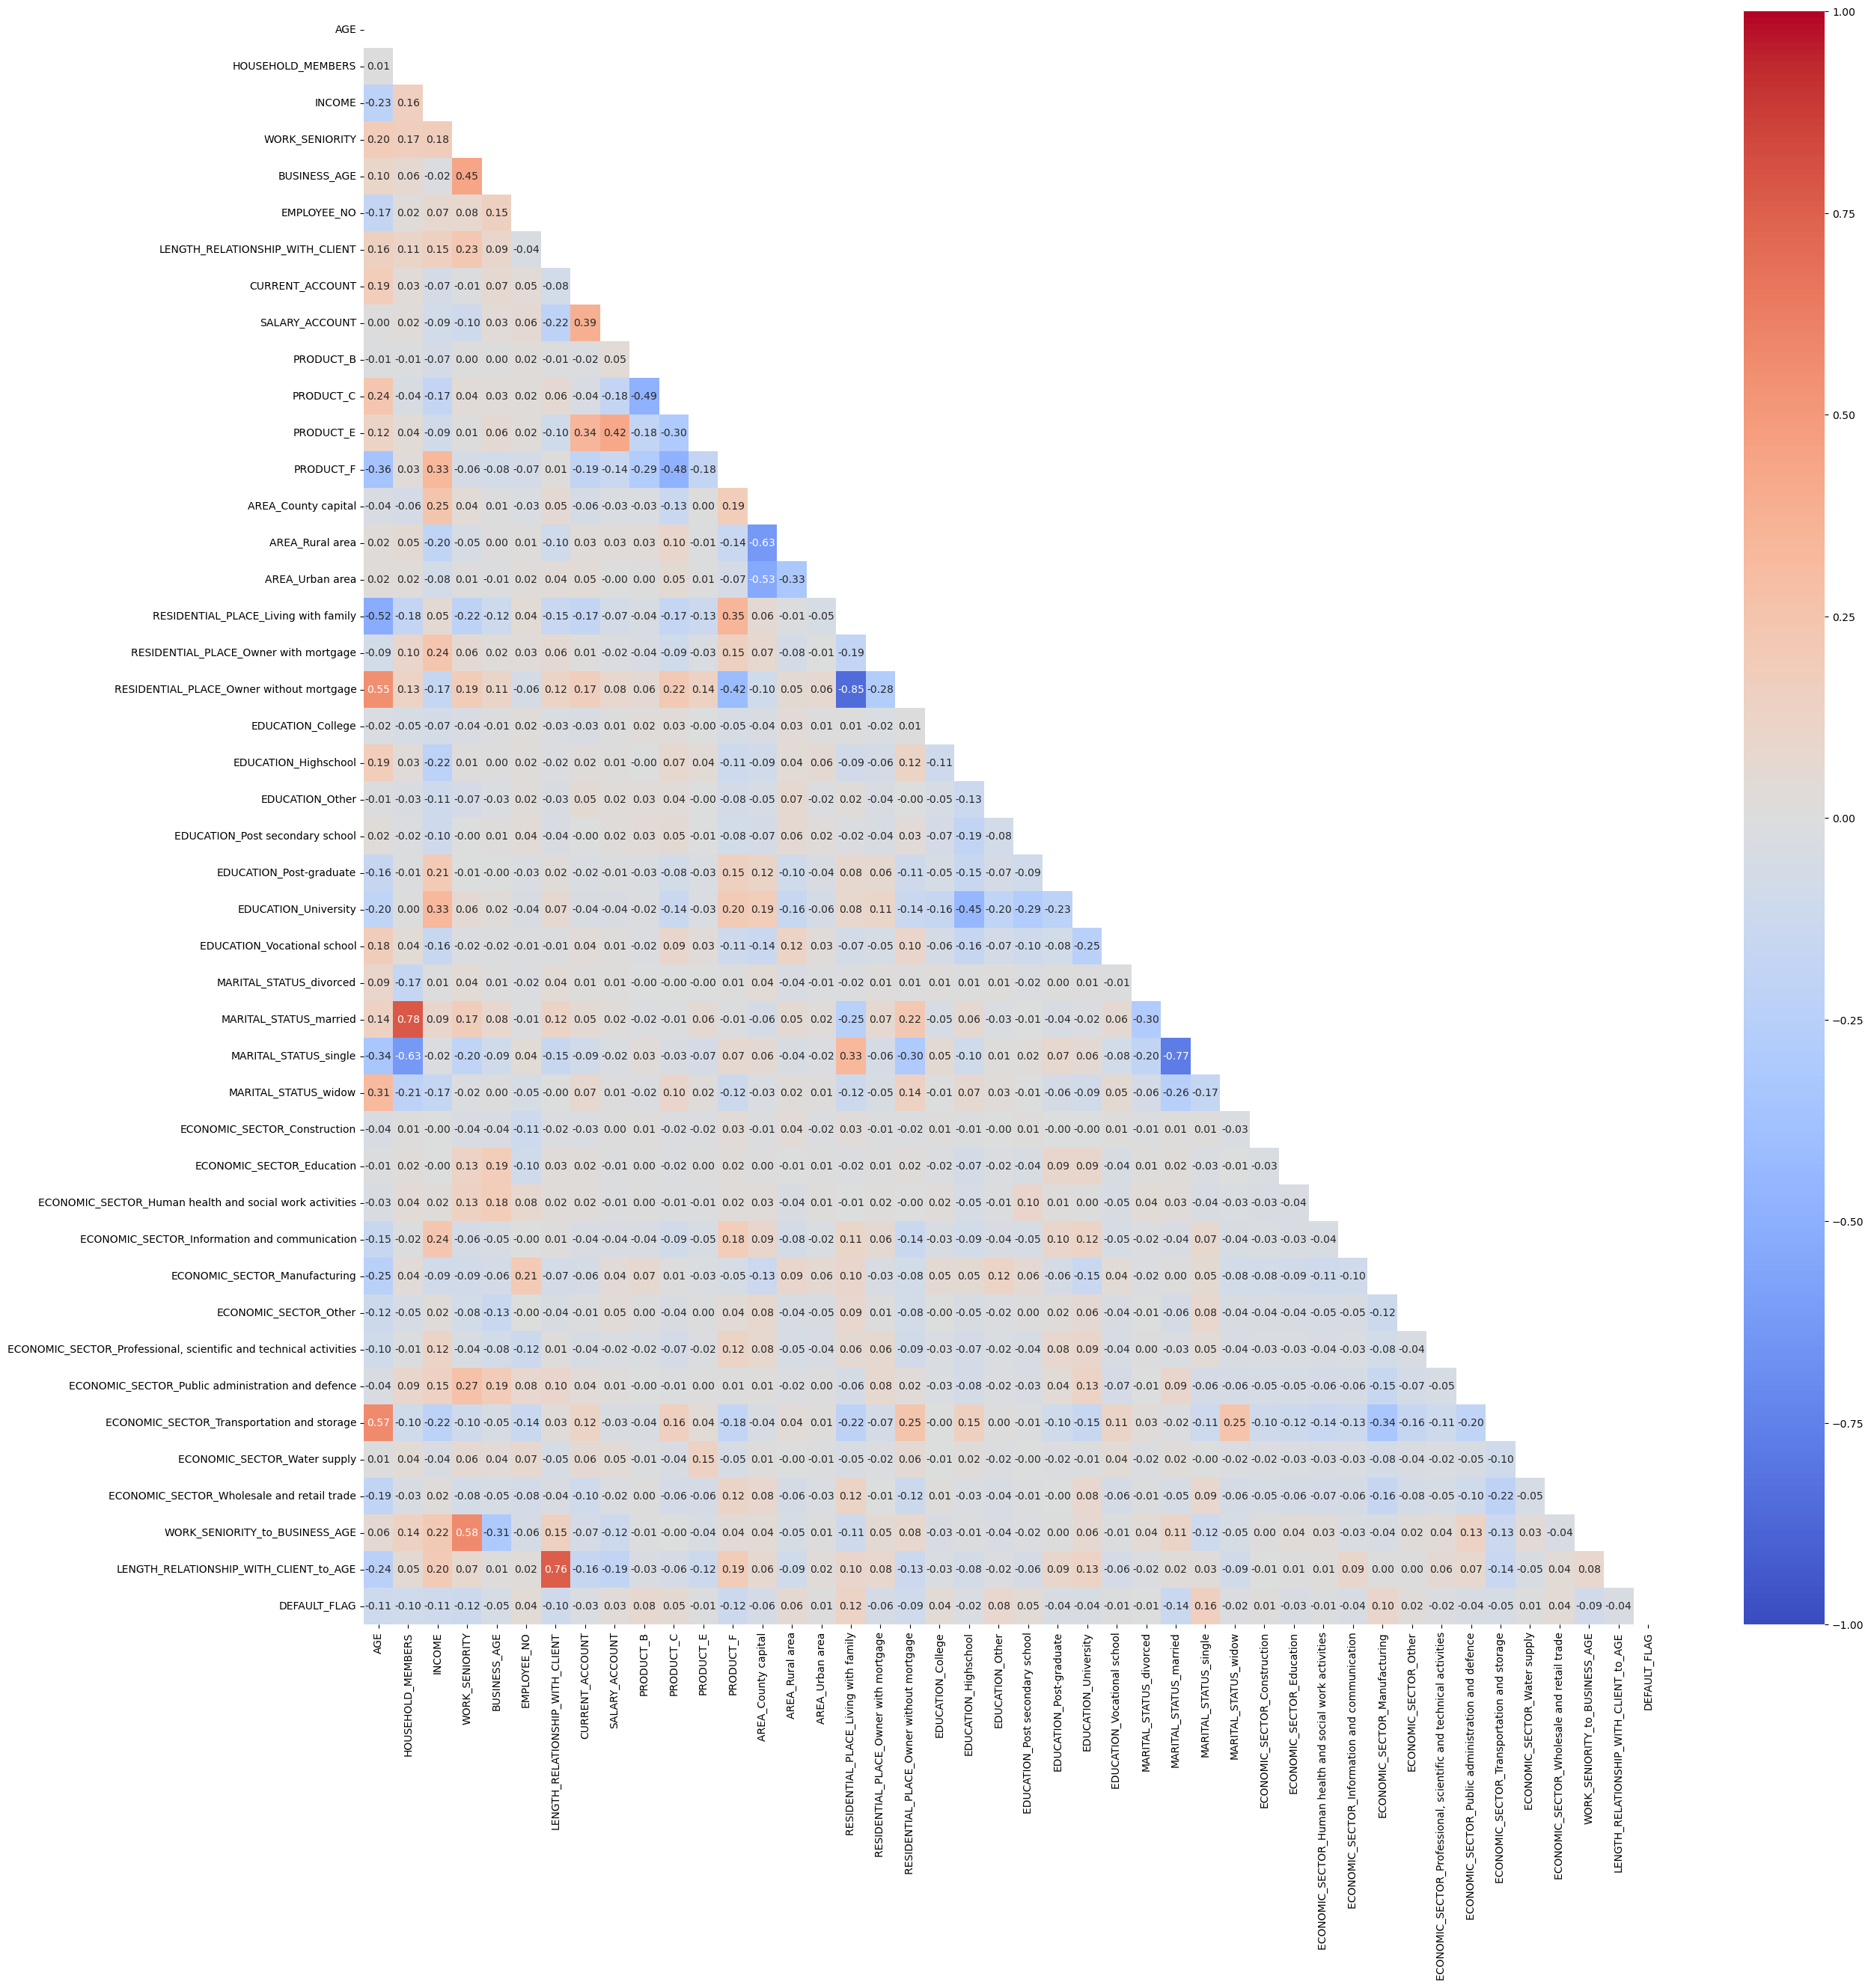

In [18]:
import seaborn as sns
from matplotlib import pyplot as plt

# Add target to X_train
full_df = X_train.assign(DEFAULT_FLAG=target)
corr_matrix = full_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)

plt.figure(figsize=(28,28))
sns.heatmap(corr_matrix, mask=mask, cmap = "coolwarm", fmt = ".2f", center = 0, vmin = -1, vmax = 1, annot=True)
plt.show()

In [19]:
X_val = pd.read_csv('../data/orig_valid.csv')

y_val = X_val['DEFAULT_FLAG']
X_val.drop(columns=['DEFAULT_FLAG'], inplace=True)

X_val = pipeline_processing.transform(X_val)
X_val = pipeline_engineering.transform(X_val)

### Metrics and printing functions

In [20]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def model_scoring(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    
    train_f1 = f1_score(y_train, y_train_pred)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_recall = recall_score(y_train, y_train_pred)

    # prediction on validation data
    y_val_pred = model.predict(X_val)

    # 
    val_f1 = f1_score(y_val, y_val_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)

    results = [
        ["Train", train_f1, train_accuracy, train_recall],
        ["Validation", val_f1, val_accuracy, val_recall]
    ]

    print(tabulate(results, headers=["Dataset", "F1 Score", "Accuracy", "Recall"], tablefmt="simple"))

    return y_train_pred, y_val_pred

def print_cm(target, target_pred):
    cm = confusion_matrix(target, target_pred)
    cm_list = cm.tolist()

    headers = ["Predicted 0", "Predicted 1"]
    labels = ["Actual 0", "Actual 1"]

    cm_percentage = np.round(cm / cm.sum(axis=1)[:, np.newaxis] * 100, 2)
    cm_percentage_list = cm_percentage.tolist()

    for i in range(len(cm_list)):
        for j in range(len(cm_list[i])):
            cm_list[i][j] = f"{cm_list[i][j]} ({cm_percentage_list[i][j]}%)"

    print(tabulate(cm_list, headers=headers, showindex=labels, tablefmt="simple"))

def plot_roc(model, X_val, y_val):
    # Calculate the probabilities of the positive class
    probs = model.predict_proba(X_val)[:, 1]

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, probs)

    # Compute the AUC score
    auc = roc_auc_score(y_val, probs)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='deepskyblue', lw=1, label='ROC curve (AUC = {:.2f})'.format(auc))
    plt.plot([0, 1], [0, 1], color='sandybrown', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def print_metrics(model, X_train, y_train, X_val, y_val):
    y_train_pred, y_val_pred = model_scoring(model, X_train, y_train, X_val, y_val)

    print('\n--- Confusion matrices --- \n')
    print(' --- Training data --- \n')
    print_cm(y_train, y_train_pred)
    print('\n --- Validation data --- \n')
    print_cm(y_val, y_val_pred)
    plot_roc(model, X_val, y_val)

Dataset       F1 Score    Accuracy    Recall
----------  ----------  ----------  --------
Train         0.859948    0.985825  0.760417
Validation    0.44186     0.955487  0.308108

--- Confusion matrices --- 

 --- Training data --- 

          Predicted 0     Predicted 1
--------  --------------  -------------
Actual 0  14226 (99.95%)  7 (0.05%)
Actual 1  207 (23.96%)    657 (76.04%)

 --- Validation data --- 

          Predicted 0    Predicted 1
--------  -------------  -------------
Actual 0  3034 (99.48%)  16 (0.52%)
Actual 1  128 (69.19%)   57 (30.81%)


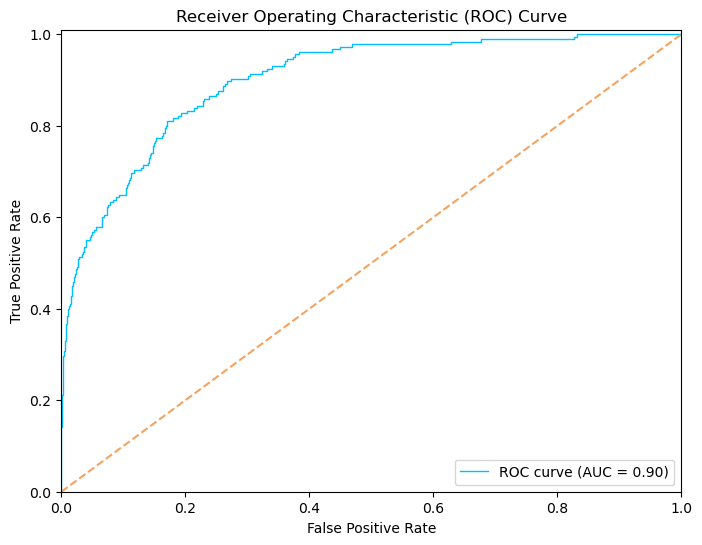

In [21]:
from xgboost import XGBClassifier 

model = XGBClassifier()

print_metrics(model, X_train, y_train, X_val, y_val)

## RandomForestClassifier

Dataset       F1 Score    Accuracy     Recall
----------  ----------  ----------  ---------
Train        0.0859978    0.945088  0.0451389
Validation   0.0717949    0.944049  0.0378378

--- Confusion matrices --- 

 --- Training data --- 

          Predicted 0     Predicted 1
--------  --------------  -------------
Actual 0  14229 (99.97%)  4 (0.03%)
Actual 1  825 (95.49%)    39 (4.51%)

 --- Validation data --- 

          Predicted 0    Predicted 1
--------  -------------  -------------
Actual 0  3047 (99.9%)   3 (0.1%)
Actual 1  178 (96.22%)   7 (3.78%)


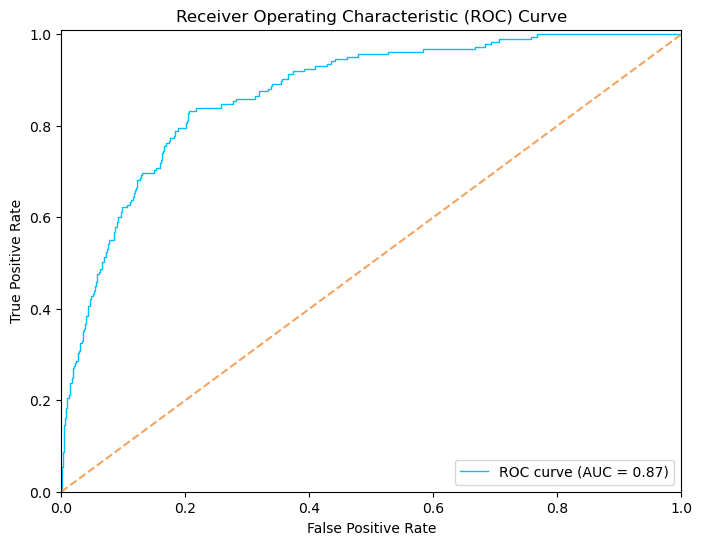

In [22]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=25, min_samples_leaf=10)

print_metrics(model, X_train, y_train, X_val, y_val)

## Logistic Regression

Dataset       F1 Score    Accuracy     Recall
----------  ----------  ----------  ---------
Train        0.0228311    0.9433    0.0115741
Validation   0.0213904    0.943431  0.0108108

--- Confusion matrices --- 

 --- Training data --- 

          Predicted 0     Predicted 1
--------  --------------  -------------
Actual 0  14231 (99.99%)  2 (0.01%)
Actual 1  854 (98.84%)    10 (1.16%)

 --- Validation data --- 

          Predicted 0    Predicted 1
--------  -------------  -------------
Actual 0  3050 (100.0%)  0 (0.0%)
Actual 1  183 (98.92%)   2 (1.08%)


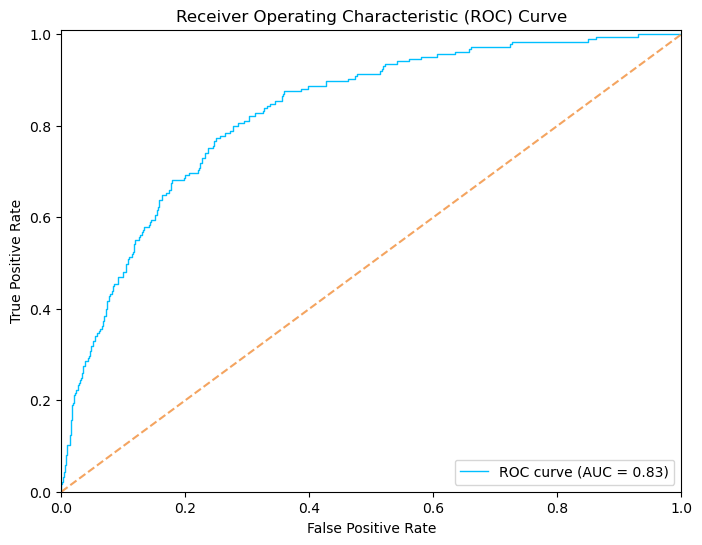

In [23]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
print_metrics(model, X_train, y_train, X_val, y_val)